In [ ]:
from google.colab import drive 
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [ ]:
import time
import math
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [ ]:
confid = 0.5
thresh = 0.5
vname=input("Video name in videos folder:  ")
if(vname==""):
    vname="Town.mp4"
vid_path = "/content/drive/MyDrive/Colab Notebooks/Social-Distancing-Analyser-COVID-19-master/Social-Distancing-Analyser-COVID-19-master/videos/video.mp4"+vname
angle_factor = 0.8
H_zoom_factor = 1.2

Video name in videos folder:  video.mp4


In [ ]:
def dist(c1, c2):
    return ((c1[0] - c2[0]) ** 2 + (c1[1] - c2[1]) ** 2) ** 0.5

def T2S(T):
    S = abs(T/((1+T**2)**0.5))
    return S

def T2C(T):
    C = abs(1/((1+T**2)**0.5))
    return C

def isclose(p1,p2):

    c_d = dist(p1[2], p2[2])
    if(p1[1]<p2[1]):
        a_w = p1[0]
        a_h = p1[1]
    else:
        a_w = p2[0]
        a_h = p2[1]

    T = 0
    try:
        T=(p2[2][1]-p1[2][1])/(p2[2][0]-p1[2][0])
    except ZeroDivisionError:
        T = 1.633123935319537e+16
    S = T2S(T)
    C = T2C(T)
    d_hor = C*c_d
    d_ver = S*c_d
    vc_calib_hor = a_w*1.3
    vc_calib_ver = a_h*0.4*angle_factor
    c_calib_hor = a_w *1.7
    c_calib_ver = a_h*0.2*angle_factor
    # print(p1[2], p2[2],(vc_calib_hor,d_hor),(vc_calib_ver,d_ver))
    if (0<d_hor<vc_calib_hor and 0<d_ver<vc_calib_ver):
        return 1
    elif 0<d_hor<c_calib_hor and 0<d_ver<c_calib_ver:
        return 2
    else:
        return 0

In [ ]:
labelsPath = "/content/drive/MyDrive/Colab Notebooks/Social-Distancing-Analyser-COVID-19-master/Social-Distancing-Analyser-COVID-19-master/coco.names"
LABELS = open(labelsPath).read().strip().split("\n")

In [ ]:
np.random.seed(42)

In [ ]:
weightsPath = "/content/drive/MyDrive/Colab Notebooks/Social-Distancing-Analyser-COVID-19-master/yolov3.weights"
configPath = "/content/drive/MyDrive/Colab Notebooks/Social-Distancing-Analyser-COVID-19-master/yolov3.cfg"

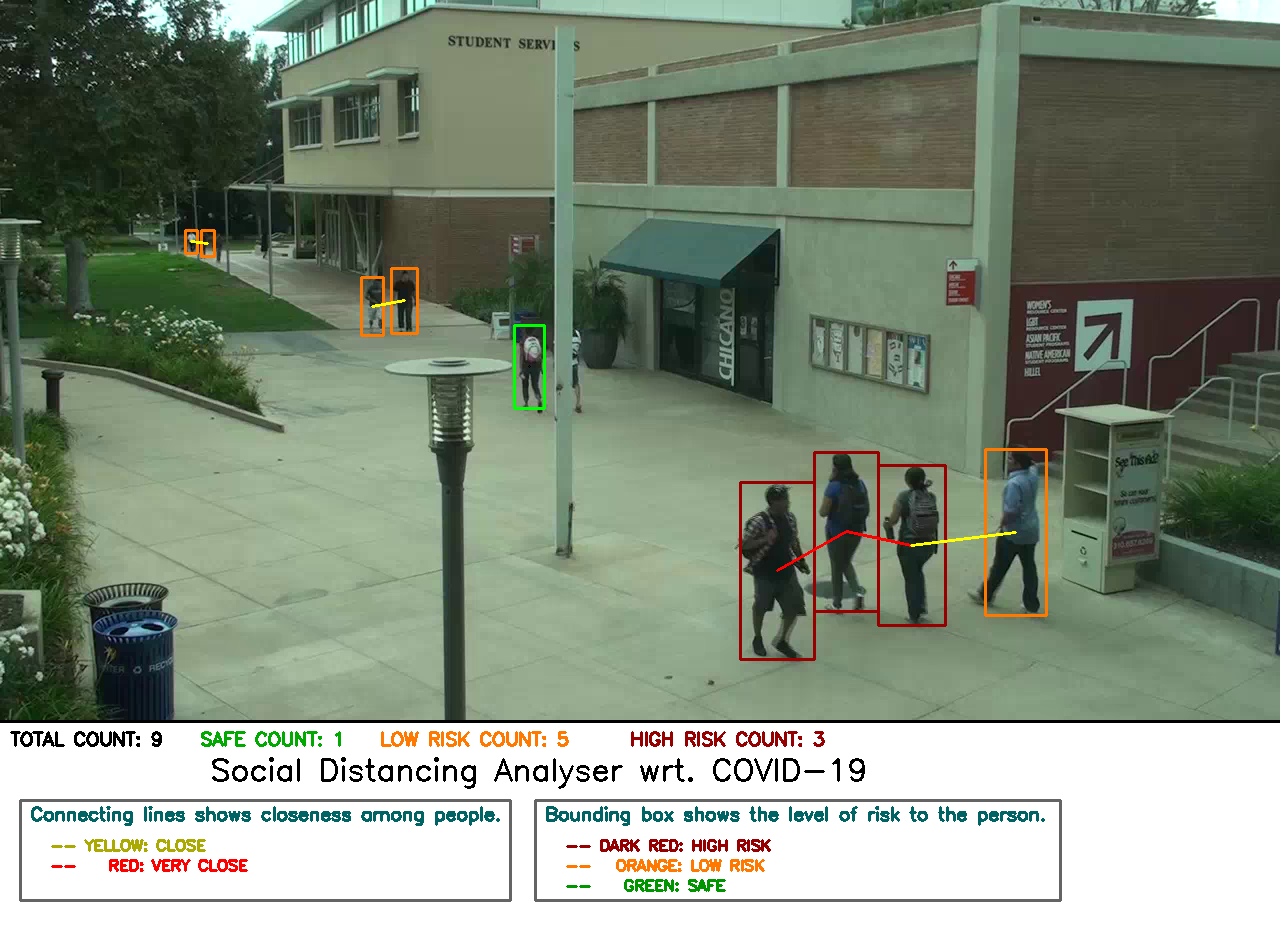

In [ ]:
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

vs = cv2.VideoCapture(vid_path)
writer = None
(W, H) = (None, None)

fl = 0
q = 0
while True:

    (grabbed, frame) = vs.read()

    if not grabbed:
        break

    if W is None or H is None:
        (H, W) = frame.shape[:2]
        FW=W
        if(W<1075):
            FW = 1075
        FR = np.zeros((H+210,FW,3), np.uint8)

        col = (255,255,255)
        FH = H + 210
    FR[:] = col

    #frame = frame[0:H, 200:q]
    #(H, W) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
                                 swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)
    end = time.time()

    boxes = []
    confidences = []
    classIDs = []

    for output in layerOutputs:

        for detection in output:

            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            if LABELS[classID] == "person":

                if confidence > confid:
                    box = detection[0:4] * np.array([W, H, W, H])
                    (centerX, centerY, width, height) = box.astype("int")

                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))

                    boxes.append([x, y, int(width), int(height)])
                    confidences.append(float(confidence))
                    classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, confid, thresh)

    if len(idxs) > 0:

        status = []
        idf = idxs.flatten()
        close_pair = []
        s_close_pair = []
        center = []
        co_info = []
        for i in idf:
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            cen=[int(x + w / 2),int(y + h / 2)]
            center.append(cen)
            cv2.circle(frame, tuple(cen),1,(0,0,0),1)
            co_info.append([w, h, cen])

            status.append(0)
        for i in range(len(center)):
            for j in range(len(center)):
                g = isclose(co_info[i], co_info[j])

                if g == 1:

                    close_pair.append([center[i], center[j]])
                    status[i] = 1
                    status[j] = 1
                elif g == 2:
                    s_close_pair.append([center[i], center[j]])
                    if status[i] != 1:
                        status[i] = 2
                    if status[j] != 1:
                        status[j] = 2

        total_p = len(center)
        low_risk_p = status.count(2)
        high_risk_p = status.count(1)
        safe_p = status.count(0)
        kk = 0

        for i in idf:
            cv2.line(FR,(0,H+1),(FW,H+1),(0,0,0),2)
            cv2.putText(FR, "Social Distancing Analyser wrt. COVID-19", (210, H+60),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
            cv2.rectangle(FR, (20, H+80), (510, H+180), (100, 100, 100), 2)
            cv2.putText(FR, "Connecting lines shows closeness among people. ", (30, H+100),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (100, 100, 0), 2)
            cv2.putText(FR, "-- YELLOW: CLOSE", (50, H+90+40),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 170, 170), 2)
            cv2.putText(FR, "--    RED: VERY CLOSE", (50, H+40+110),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

            cv2.rectangle(FR, (535, H+80), (1060, H+140+40), (100, 100, 100), 2)
            cv2.putText(FR, "Bounding box shows the level of risk to the person.", (545, H+100),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (100, 100, 0), 2)
            cv2.putText(FR, "-- DARK RED: HIGH RISK", (565, H+90+40),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 150), 2)
            cv2.putText(FR, "--   ORANGE: LOW RISK", (565, H+150),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 120, 255), 2)

            cv2.putText(FR, "--    GREEN: SAFE", (565, H+170),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 2)

            
            tot_str = "TOTAL COUNT: " + str(total_p)
            high_str = "HIGH RISK COUNT: " + str(high_risk_p)
            low_str = "LOW RISK COUNT: " + str(low_risk_p)
            safe_str = "SAFE COUNT: " + str(safe_p)

            cv2.putText(FR, tot_str, (10, H +25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
            cv2.putText(FR, safe_str, (200, H +25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 170, 0), 2)
            cv2.putText(FR, low_str, (380, H +25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 120, 255), 2)
            cv2.putText(FR, high_str, (630, H +25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 150), 2)

            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            if status[kk] == 1:
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 150), 2)

            elif status[kk] == 0:
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

            else:
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 120, 255), 2)

            kk += 1
        for h in close_pair:
            cv2.line(frame, tuple(h[0]), tuple(h[1]), (0, 0, 255), 2)
        for b in s_close_pair:
            cv2.line(frame, tuple(b[0]), tuple(b[1]), (0, 255, 255), 2)
        FR[0:H, 0:W] = frame
        frame = FR
        cv2_imshow(frame)
        cv2.waitKey(1)

        if writer is None:
         fourcc = cv2.VideoWriter_fourcc(*"MJPG")
         writer = cv2.VideoWriter("op_"+vname, fourcc, 30,
                                 (frame.shape[1], frame.shape[0]), True)

    writer.write(frame)
print("Processing finished: open"+"op_"+vname)
writer.release()
vs.release()